# 2.4
- Jag vill se ifall vi predikera ifall någon är positiv för cardiovascular disease.
- I detta fallet använder jag df_2, men jag tror att df_1 hade funkat också
- Efter jag hade kollat runt lite på modeller som ska vara bra på kategorisk data kom jag fram till att jag vill testa:
* KNN
* Random Forest
* SVM(SVC)
* Logistic Regression
-----------------------------------------------------------------------
* Jag vill testa lite olika typer av hyperparametrar för att hitta den optimala kombinationen av värden som kan förbättra prestandan av mina modeller. Alltså varje hyperparameter kan påverka modellens förmåga att lära sig och generalisera från datan.

* Vad som är viktigt för framtida test av hyperparametrar är att få en bättre förståelse för vad det är som kräver mycket prestanda från datorn. Alltså, vilka tester av hyperparametrar är det som tar längst tid att genomföra. Kan man få en bra förståelse för det här kan man alltså optimera för sig själv genom att kunna testa så många olika hyperparametrar som möjligt på så kort tid som möjligt.

### Recall är viktigare eftersom vi vill inte ha false negatives
### Accuracy är viktigare om vi vill ha mindre false positives

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## Code for dfs to be correct
- taken from 2.1, just formats the dfs to be correct.

In [9]:
df = pd.read_csv("../Labb/Disease_prediction/cardio_train.csv", sep=";")

df["age"] = round(df["age"]/365).astype(int) 

df['BMI'] = df['weight'] / (df['height']/100)**2

# remove outliers that are below 15 and above 50
df = df[df['BMI'] > 15]
df = df[df['BMI'] < 50]

df['BMI'].min(), df['BMI'].max()

df['BMI_category'] = df['BMI'].apply(lambda x: 1 if x < 25 else 2 if x < 30 else 3)

# removing outliers
# set the limits for systolic blood pressure to 90-200 and for diastolic blood pressure to 60-145
# From what I can find, you have hypotension (low blood pressure) if you go below 90/60.
df = df[df['ap_hi'] > 90]
df = df[df['ap_hi'] < 200] # set it to 200 since the next highest recorded value in the dataset is 197 for systolic blood pressure
# and systolic pressure above 180 is potentially life-threatening, which means not alot of people will have a systolic blood pressure above 200

# diastolic blood pressure limits
# From what I can find, you have hypotension (low blood pressure) if you go below 60 diastolic blood pressure.
df = df[df['ap_lo'] > 60]
df = df[df['ap_lo'] < 145] # set the limit to 145 since the highest recorded value in the dataset is 140 for diastolic blood pressure


df = df[df['ap_hi'] > df['ap_lo']] # removes all rows where the diastolic blood pressure is higher than the systolic blood pressure

for index, row in df.iterrows():
    sys_bp = row['ap_hi']
    dia_bp = row['ap_lo']

    new_col = 'BP_category'

    # Categorize the blood pressure according to the standard guidelines from wikipedia
    if sys_bp < 120 and dia_bp < 80:
        df.at[index, new_col] = 1
    elif sys_bp < 130 and dia_bp < 80:
        df.at[index, new_col] = 2
    elif sys_bp < 140 or dia_bp < 90:
        df.at[index, new_col] = 3
    elif sys_bp < 180 or dia_bp < 120:
        df.at[index, new_col] = 4
    elif sys_bp > 180 or dia_bp > 120:
        df.at[index, new_col] = 5

df_1 = df.drop(['ap_hi', 'ap_lo', 'height', 'weight', 'BMI'], axis=1)
df_2 = df.drop(['height', 'weight', 'BMI_category', 'BP_category'], axis=1)

In [10]:
df_2.drop('id', axis=1, inplace=True) # did not want to keep this column since id is arbitrary and might mess up the model accuracy

In [11]:
from sklearn.model_selection import train_test_split

# splitting the data into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(df_2.drop('cardio', axis=1), df_2['cardio'], test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)


In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# standardizing the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# normalizing the features
normalizer = MinMaxScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

# pretty much no difference between standardizing and normalizing features both indivudually and together

## Förklaringar för dem olika hyperparametrarna:

### SVM hyperparametrar: kernel & gamma
* Kernel-hyperparametern kontrollerar formen på beslutsgränsen i SVM-modellen. De vanligaste alternativen är linjär, polynomisk och radial basisfunktion (RBF).
* Gamma-hyperparametern kontrollerar bredden på RBF-kärnan och påverkar hur tätt beslutsgränsen passar till träningsdatan.

### Random Forest hyperparametrar: max_leaf_nodes, max_depth & min_samples_depth
* Max_leaf_nodes-hyperparametern sätter det maximala antalet lövnoder i varje beslutsträd i random forest-modellen.
* Max_depth-hyperparametern sätter den maximala djupet av varje beslutsträd.
* Min_samples_leaf-hyperparametern sätter det minsta antalet exempel som krävs för att en lövnod ska skapas i varje beslutsträd.

### KNN hyperparametrar: n_neighbors, weights & metric
* N_neighbors-hyperparametern sätter antalet närmaste grannar som ska beaktas i KNN-modellen.
* Weights-hyperparametern styr hur grannarna ska vägas när en prediktion görs.
* Metric-hyperparametern sätter den avståndsmått som används för att mäta avståndet mellan punkter.

### Logistic regression hyperparametrar: penalty & solver
* Penalty-hyperparametern styr regulariseringstermen i logistisk regression. De vanligaste alternativen är L1- och L2-reglering.
* Solver-hyperparametern styr optimeringsalgoritmen som används för att passa modellen. De vanligaste alternativen är lbfgs, liblinear och sag.

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# hyperparameters for SVM
svm_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}

# hyperparameters for RF
rf_params = {'max_leaf_nodes': [1, 2, 3], 'max_depth': [2, 4, 6], 'min_samples_split': [2, 5, 10]}

# hyperparameters for KNN
k_neigh_params = {'n_neighbors': [1, 2, 5, 10, 15, 20], 'weights': ['uniform', 'distance'], "metric": ['euclidean', 'manhattan', 'minkowski']}

# hyperparameters for LR
log_reg_params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# dictionary of hyperparameters for each model
param_grids = {'KNN': k_neigh_params, 'LR': log_reg_params, 'RF': rf_params, 'SVM': svm_params}

# All scores for the hyperparameters are below

In [14]:
#models = {"KNN": KNeighborsClassifier(), "LR": LogisticRegression(), "RF": RandomForestClassifier(), "SVM": SVC()}

# performs grid search for each model
# for model_name, model in models.items():
#     grid = GridSearchCV(model, param_grid=param_grids[model_name], scoring='accuracy', cv=5)
#     grid.fit(X_train, y_train)
#     print(f"{model_name}: Best Parameters: {grid.best_params_}")
#     print(f"{model_name}: Best Score: {grid.best_score_}")
# Takes about 40 minutes to run this cell

----------------------------------SVM----------------------------------------------------------------
- Best parameters for SVM: "Gamma": "scale", "kernel": "rbf"
- Tested: "Gamma": ["auto", "scale"]
- Tested: "kernel": ['linear', 'poly', 'rbf', 'sigmoid']

-----------------------------------RF--------------------------------------------------------------
- Best parameters for RF: 'max_depth': 4, 'max_leaf_nodes': 3, 'min_samples_split': 2
- Tested:'max_leaf_nodes': [1, 2, 3]
- Tested:'max_depth': [2, 4, 6]
- Tested: 'min_samples_split': [2, 5, 10]

---------------------------------------LR-----------------------------------------------------------
- Best Parameters: {'penalty': 'l2', 'solver': 'liblinear'}
- Tested: 'penalty': ['l1', 'l2', 'elasticnet', 'none']
- Tested: 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

---------------------------------------KNN-----------------------------------------------------------
- KNN: Best Parameters: 'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'uniform'
- Tested: k_neigh_params = 'n_neighbors': [1, 2, 5, 10, 15, 20]
- Tested: 'weights': ['uniform', 'distance']
- Tested: "metric": ['euclidean', 'manhattan', 'minkowski']

In [15]:
from sklearn.metrics import accuracy_score

# testing on validation set first
svm = SVC(C=1, kernel='rbf', gamma='scale')
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_val)

rf = RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=100)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)

lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_val)

knn = KNeighborsClassifier(n_neighbors=20, weights='uniform', metric='manhattan')
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_val)


svm_acc = recall_score(y_val, svm_preds)
rf_acc = recall_score(y_val, rf_preds)
lr_acc = recall_score(y_val, lr_preds)
knn_acc = recall_score(y_val, knn_preds)

print('SVM Validation Recall:', svm_acc)
print('RF Validation Recall:', rf_acc)
print('LR Validation Recall:', lr_acc)
print('KNN Validation Recall:', knn_acc)


SVM Validation Recall: 0.6706002034587996
RF Validation Recall: 0.6756866734486267
LR Validation Recall: 0.6665310274669379
KNN Validation Recall: 0.6636826042726348


# 2.5

### Testing combining models 

              precision    recall  f1-score   support

           0       0.68      0.82      0.75      4878
           1       0.78      0.62      0.69      4915

    accuracy                           0.72      9793
   macro avg       0.73      0.72      0.72      9793
weighted avg       0.73      0.72      0.72      9793



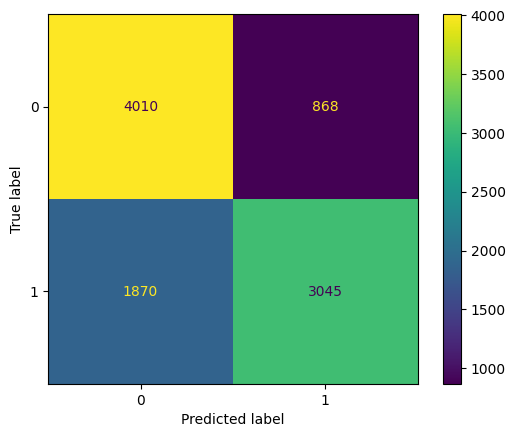

In [18]:
# import votingclassifier
#import gaussianNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    print(classification_report(y_val, y_pred))
    cm = confusion_matrix(y_val, y_pred)
    ConfusionMatrixDisplay(cm).plot()

vote_clf = VotingClassifier(
    [("rf", RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=100)),
     ("svc", SVC(kernel='rbf', gamma='scale')),
        ("knn", KNeighborsClassifier(n_neighbors=20, weights='uniform', metric='manhattan')),
        ("log_reg", LogisticRegression(penalty='l2', solver='liblinear')),
   #   ("naive_complement", ComplementNB()),
   #   ("naive_bernoulli", BernoulliNB()),
   #   ("naive_multinomail", MultinomialNB())
   ], voting="hard")


# Worse result than the best individual model for recall
# 0.01 better recall for 0 and 0.01 worse recall for 1 without naive bayes

In [ ]:
recall_score(y_val, vote_clf.predict(X_val))

0.6545269582909461

# 2.6

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      4878
           1       0.75      0.67      0.71      4915

    accuracy                           0.73      9793
   macro avg       0.73      0.73      0.72      9793
weighted avg       0.73      0.73      0.72      9793

None


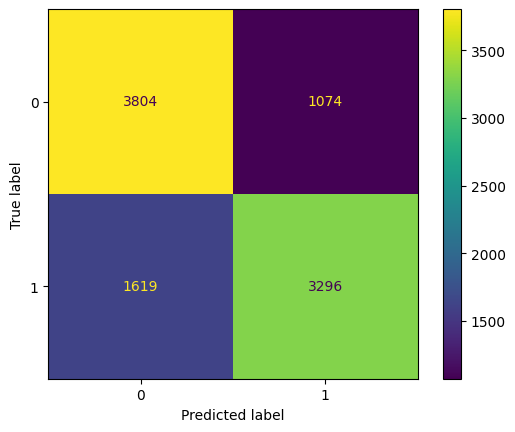

In [ ]:
print(evaluate_model(SVC(kernel='rbf', gamma='scale')))

              precision    recall  f1-score   support

           0       0.69      0.77      0.73      4878
           1       0.74      0.66      0.70      4915

    accuracy                           0.72      9793
   macro avg       0.72      0.72      0.71      9793
weighted avg       0.72      0.72      0.71      9793

None


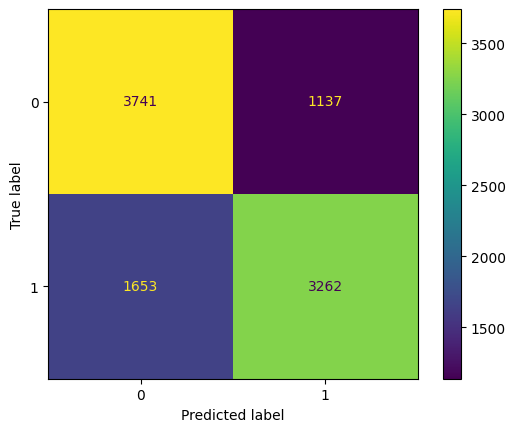

In [ ]:
print(evaluate_model(KNeighborsClassifier(n_neighbors=20, weights='uniform', metric='manhattan')))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      4878
           1       0.76      0.67      0.71      4915

    accuracy                           0.72      9793
   macro avg       0.73      0.72      0.72      9793
weighted avg       0.73      0.72      0.72      9793

None


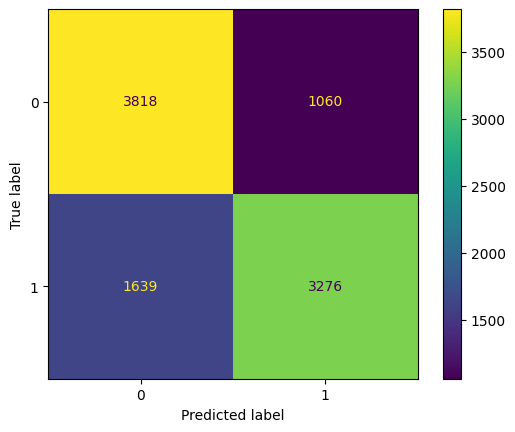

In [ ]:
print(evaluate_model(LogisticRegression(penalty='l2', solver='liblinear')))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      4878
           1       0.76      0.67      0.71      4915

    accuracy                           0.73      9793
   macro avg       0.73      0.73      0.73      9793
weighted avg       0.73      0.73      0.73      9793

None


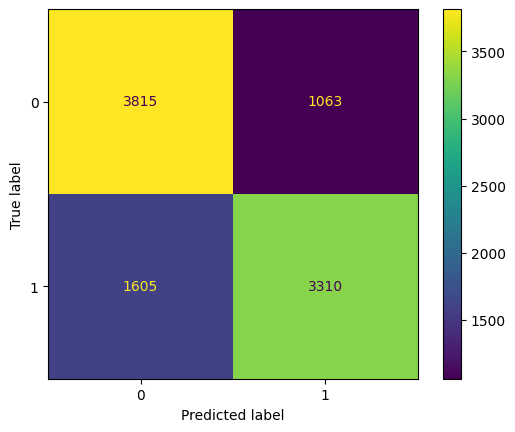

In [ ]:
print(evaluate_model(RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=100)))
# highest recall average (together with SVC)

# 2.7

In [ ]:
# pick out 100 random rows from the dataset and export to test_samples.csv
import random

test_samples = random.sample(range(0, len(df_2)), 100)
test_samples_df = df_2.iloc[test_samples]
test_samples_df.to_csv('test_samples.csv', index=False)

# removes the test_samples.csv from the dataset
df_2 = df_2.drop(test_samples_df.index)


* Best model for recall is randomforest

In [ ]:
rf = RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(df_2.drop('cardio', axis=1), df_2['cardio'], test_size=0.2, random_state=42) # train on the dataset without the test samples
rf.fit(X_train, y_train)

# save trained model
import pickle

pickle.dump(rf, open('new_rf_model.pkl', 'wb'))